In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch.nn as nn
import re
import os
import zipfile
import torch
import optuna
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras_tuner import RandomSearch, HyperParameters, Objective
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, Bidirectional, LSTM, Layer
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from transformers import BertTokenizer, TFBertModel, BertModel, get_linear_schedule_with_warmup, WarmUp, AdamW, RobertaTokenizer, TFRobertaModel, RobertaModel, XLMRobertaTokenizer, XLMRobertaModel, AutoTokenizer, logging

c:\Users\Alex\anaconda3\envs\pt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 解压 cleaned_lyrics.zip 文件
with zipfile.ZipFile('sampled.zip', 'r') as zip_ref:
    zip_ref.extractall('sampled')

# 获取所有歌词文件的路径
lyrics_files = {os.path.splitext(f)[0]: os.path.join('sampled', f) for f in os.listdir('sampled')}

# 读取 filtered_dataset.csv 文件
data = pd.read_csv('sampled_dataset.csv')

def read_lyrics(record_id):
    file_path = lyrics_files.get(str(record_id))
    if file_path and os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    return ''

# 读取歌词并添加到数据框中
data['lyrics'] = data['record_id'].apply(read_lyrics)


In [ ]:
data

# DNN Baseline

In [3]:
# 使用 Tokenizer 处理文本
max_words = 5000
max_len = 128

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['lyrics'])
sequences = tokenizer.texts_to_sequences(data['lyrics'])
X_lyrics = pad_sequences(sequences, maxlen=max_len)

# 准备标签
y_valence = to_categorical(data['valence_bin'].values)
y_energy = to_categorical(data['energy_bin'].values)
y_danceability = to_categorical(data['danceability_bin'].values)

# 拆分数据集
X_train_val, X_test, y_train_val_valence, y_test_valence, y_train_val_energy, y_test_energy, y_train_val_danceability, y_test_danceability = train_test_split(
    X_lyrics, y_valence, y_energy, y_danceability, test_size=0.2, random_state=42)

X_train, X_val, y_train_valence, y_val_valence, y_train_energy, y_val_energy, y_train_danceability, y_val_danceability = train_test_split(
    X_train_val, y_train_val_valence, y_train_val_energy, y_train_val_danceability, test_size=0.2, random_state=42)


In [ ]:
y_train_valence

In [ ]:
X_train.shape

In [ ]:
# max_len = X_train.shape[1]
# max_words = len(tokenizer.word_index) + 1

# inputs = Input(shape=(max_len,))

# x = Embedding(input_dim=max_words, output_dim=128, input_length=max_len)(inputs)

# x = Bidirectional(LSTM(64, return_sequences=True))(x)
# x = Dropout(0.2)(x)

# x = Bidirectional(LSTM(32))(x)
# x = Dropout(0.2)(x)

# outputs = Dense(3, activation='softmax')(x)

# model = Model(inputs=inputs, outputs=outputs)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
from keras_tuner import RandomSearch, HyperParameters, Objective
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding, Flatten
from keras.callbacks import EarlyStopping


# 构建模型函数
def build_model(hp):
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=hp.Int('input_dim', min_value=1000, max_value=10000, step=1000),
                  output_dim=hp.Int('output_dim', min_value=32, max_value=128, step=32))(inputs)
    x = Flatten()(x)

    num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)
    for i in range(num_layers):
        if i == 0:
            x = Dense(units=hp.Int(f'units_layer{i+1}', min_value=32, max_value=512, step=32), activation='relu')(x)
        else:
            x = Dense(units=hp.Int(f'units_layer{i+1}', min_value=32, max_value=512, step=32), activation='relu')(x)
        x = Dropout(rate=hp.Float(f'dropout_layer{i+1}', min_value=0.0, max_value=0.5, step=0.1))(x)

    x = Dense(units=hp.Int('units_final', min_value=32, max_value=512, step=32),
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_regularization', values=[0.0, 1e-4, 1e-3])),
              kernel_initializer=hp.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal']))(x)

    
    output_valence = Dense(y_valence.shape[1], activation='softmax', name='valence_output')(x)
    output_energy = Dense(y_energy.shape[1], activation='softmax', name='energy_output')(x)
    output_danceability = Dense(y_danceability.shape[1], activation='softmax', name='danceability_output')(x)
    
    model = Model(inputs=inputs, outputs=[output_valence, output_energy, output_danceability])

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss={'valence_output': 'categorical_crossentropy', 
                        'energy_output': 'categorical_crossentropy', 
                        'danceability_output': 'categorical_crossentropy'},
                  metrics={'valence_output': 'accuracy', 
                           'energy_output': 'accuracy', 
                           'danceability_output': 'accuracy'})
    return model

# 超参数调优
dnn_tuner = RandomSearch(
    build_model,
    objective=Objective('val_valence_output_accuracy', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='dnn_mood_detection_600'
)

In [9]:
# 启动调优过程
dnn_tuner.search(X_train, [y_train_valence, y_train_energy, y_train_danceability], 
             epochs=20,
             validation_data=(X_val, [y_val_valence, y_val_energy, y_val_danceability]), 
             callbacks=[EarlyStopping(patience=3)])

# 获取最佳模型

best_model_DNN = dnn_tuner.get_best_models(num_models=1)[0]
best_hyperparameters_DNN = dnn_tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters_DNN.values)

Trial 10 Complete [00h 00m 01s]

Best val_valence_output_accuracy So Far: 0.5520833134651184
Total elapsed time: 00h 00m 22s
{'input_dim': 9000, 'output_dim': 96, 'num_layers': 5, 'units_layer1': 96, 'dropout_layer1': 0.2, 'units_final': 384, 'l2_regularization': 0.0, 'kernel_initializer': 'glorot_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'units_layer2': 32, 'dropout_layer2': 0.0, 'units_layer3': 32, 'dropout_layer3': 0.0, 'units_layer4': 32, 'dropout_layer4': 0.0, 'units_layer5': 32, 'dropout_layer5': 0.0}


c:\Users\Alex\anaconda3\envs\pt\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# # 评估模型

# loss, valence_output_loss, energy_output_loss, danceability_output_loss, accuracy_valence, accuracy_energy, accuracy_danceability = best_model.evaluate(X_test, [y_test_valence, y_test_energy, y_test_danceability])
# print(f'Test Loss: {loss}, valence_output_loss: {valence_output_loss}, energy_output_loss: {energy_output_loss}, danceability_output_loss: {danceability_output_loss}, Test Accuracy Valence: {accuracy_valence}, Test Accuracy Energy: {accuracy_energy}, Test Accuracy Danceability: {accuracy_danceability}')

In [ ]:
metrics = best_model_DNN.evaluate(X_test, [y_test_valence, y_test_energy, y_test_danceability])
#print(f'Test Loss: {loss}, Test Accuracy Valence: {accuracy_valence}, Test Accuracy Energy: {accuracy_energy}, Test Accuracy Danceability: {accuracy_danceability}')
print(metrics)

# Bi-LSTM

In [10]:
def build_model_LSTM(hp):
    inputs = Input(shape=(max_len,))
    
    x = Embedding(input_dim=hp.Int('input_dim', min_value=5000, max_value=20000, step=1000),
                output_dim=hp.Int('output_dim', min_value=64, max_value=256, step=32))(inputs)

    for _ in range(hp.Int('num_lstm_layers', 1, 2)):
        x = Bidirectional(LSTM(units=hp.Int('units_lstm', min_value=64, max_value=256, step=32),
                            return_sequences=True))(x)
        x = Dropout(rate=hp.Float('dropout_lstm', min_value=0.1, max_value=0.3, step=0.1))(x)

    x = Bidirectional(LSTM(units=hp.Int('units_lstm', min_value=64, max_value=256, step=32),
                        return_sequences=False))(x)
    x = Dropout(rate=hp.Float('dropout_lstm', min_value=0.1, max_value=0.3, step=0.1))(x)

    x = Dense(units=hp.Int('units_dense', min_value=64, max_value=256, step=32), activation='relu')(x)
    x = Dropout(rate=hp.Float('dropout_dense', min_value=0.1, max_value=0.3, step=0.1))(x)
    
    output_valence = Dense(y_valence.shape[1], activation='softmax', name='valence_output')(x)
    output_energy = Dense(y_energy.shape[1], activation='softmax', name='energy_output')(x)
    output_danceability = Dense(y_danceability.shape[1], activation='softmax', name='danceability_output')(x)
    
    model = Model(inputs=inputs, outputs=[output_valence, output_energy, output_danceability])

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss={'valence_output': 'categorical_crossentropy', 
                        'energy_output': 'categorical_crossentropy', 
                        'danceability_output': 'categorical_crossentropy'},
                  metrics={'valence_output': 'accuracy', 
                           'energy_output': 'accuracy', 
                           'danceability_output': 'accuracy'})
    
    return model

In [11]:
tuner_LSTM = RandomSearch(
    build_model_LSTM,
    objective=Objective('val_valence_output_accuracy', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='bi_lstm_mood_detection'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Launch the search
tuner_LSTM.search(X_train, [y_train_valence, y_train_energy, y_train_danceability], 
             epochs=20, 
             validation_data=(X_val, [y_val_valence, y_val_energy, y_val_danceability]), 
             callbacks=[early_stopping])

Trial 10 Complete [00h 01m 14s]
val_valence_output_accuracy: 0.4479166567325592

Best val_valence_output_accuracy So Far: 0.5
Total elapsed time: 00h 06m 40s


In [12]:
best_model_LSTM = tuner_LSTM.get_best_models(num_models=1)[0]
best_model_LSTM.summary()

# Evaluate the best model
results = best_model_LSTM.evaluate(X_val, [y_val_valence, y_val_energy, y_val_danceability])
print("Validation Loss and Accuracy:", results)

c:\Users\Alex\anaconda3\envs\pt\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 56 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 224)  │  1,568,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 512)  │    985,088 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 512)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128, 512)  │  1,574,912 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 512)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 512)       │  1,574,912 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 224)       │    114,912 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 224)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ valence_output      │ (None, 3)         │        675 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ energy_output       │ (None, 3)         │        675 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ danceability_output │ (None, 3)         │        675 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,819,849 (22.20 MB)

 Trainable params: 5,819,849 (22.20 MB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - danceability_output_accuracy: 0.4388 - energy_output_accuracy: 0.2552 - loss: 3.3616 - valence_output_accuracy: 0.4609
Validation Loss and Accuracy: [3.2785587310791016, 0.4479166567325592, 0.2916666567325592, 0.5]


# CNN

In [13]:
# 构建 CNN 模型函数
def build_cnn_model(hp):
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=max_words, output_dim=hp.Int('embedding_output_dim', min_value=32, max_value=128, step=32), input_length=max_len)(inputs)
    x = tf.keras.layers.Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32), kernel_size=hp.Int('kernel_size', min_value=3, max_value=7, step=2), activation='relu')(x)
    x = tf.keras.layers.AveragePooling1D(pool_size=hp.Int('pool_size', min_value=2, max_value=5, step=1))(x)
    x = Flatten()(x)
    
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    for i in range(num_layers):
        x = Dense(units=hp.Int(f'dense_units_{i+1}', min_value=32, max_value=512, step=32), activation='relu')(x)
        x = Dropout(rate=hp.Float(f'dropout_{i+1}', min_value=0.0, max_value=0.5, step=0.1))(x)
    
    output_valence = Dense(y_valence.shape[1], activation='softmax', name='valence_output')(x)
    output_energy = Dense(y_energy.shape[1], activation='softmax', name='energy_output')(x)
    output_danceability = Dense(y_danceability.shape[1], activation='softmax', name='danceability_output')(x)
    
    model = Model(inputs=inputs, outputs=[output_valence, output_energy, output_danceability])

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss={'valence_output': 'categorical_crossentropy', 
                        'energy_output': 'categorical_crossentropy', 
                        'danceability_output': 'categorical_crossentropy'},
                  metrics={'valence_output': 'accuracy', 
                           'energy_output': 'accuracy', 
                           'danceability_output': 'accuracy'})
    return model

# 超参数调优
tuner_CNN = RandomSearch(
    build_cnn_model,
    objective=Objective('val_valence_output_accuracy', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_mood_detection_600'
)

# 启动调优过程
tuner_CNN.search(X_train, [y_train_valence, y_train_energy, y_train_danceability], 
             epochs=20, 
             validation_data=(X_val, [y_val_valence, y_val_energy, y_val_danceability]), 
             callbacks=[EarlyStopping(patience=3)])

# 获取最佳模型
best_model_CNN = tuner_CNN.get_best_models(num_models=1)[0]
best_hyperparameters_CNN = tuner_CNN.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters_CNN.values)

Trial 10 Complete [00h 00m 02s]
val_valence_output_accuracy: 0.3645833432674408

Best val_valence_output_accuracy So Far: 0.5625
Total elapsed time: 00h 00m 28s
{'embedding_output_dim': 96, 'filters': 96, 'kernel_size': 7, 'pool_size': 5, 'num_layers': 3, 'dense_units_1': 288, 'dropout_1': 0.0, 'optimizer': 'rmsprop', 'learning_rate': 0.001, 'dense_units_2': 224, 'dropout_2': 0.30000000000000004, 'dense_units_3': 32, 'dropout_3': 0.0}


c:\Users\Alex\anaconda3\envs\pt\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 17 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
metrics_CNN = best_model_CNN.evaluate(X_test, [y_test_valence, y_test_energy, y_test_danceability])
#print(f'Test Loss: {loss}, Test Accuracy Valence: {accuracy_valence}, Test Accuracy Energy: {accuracy_energy}, Test Accuracy Danceability: {accuracy_danceability}')
print(metrics)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - danceability_output_accuracy: 0.4052 - energy_output_accuracy: 0.4340 - loss: 3.6213 - valence_output_accuracy: 0.5440  
<module 'sklearn.metrics' from 'c:\\Users\\Alex\\anaconda3\\envs\\pt\\Lib\\site-packages\\sklearn\\metrics\\__init__.py'>


In [ ]:
# # 评估模型
# loss, valence_output_loss, energy_output_loss, danceability_output_loss, accuracy_valence, accuracy_energy, accuracy_danceability = best_model.evaluate(X_test, [y_test_valence, y_test_energy, y_test_danceability])
# print(f'Test Loss: {loss}, valence_output_loss: {valence_output_loss}, energy_output_loss: {energy_output_loss}, danceability_output_loss: {danceability_output_loss}, Test Accuracy Valence: {accuracy_valence}, Test Accuracy Energy: {accuracy_energy}, Test Accuracy Danceability: {accuracy_danceability}')

# Transformer

In [15]:
num_labels = 3

class MultiLabelBERT(nn.Module):
    def __init__(self, model_name, num_labels_valence, num_labels_energy, num_labels_danceability, dropout_rate):
        super(MultiLabelBERT, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier_valence = nn.Linear(self.bert.config.hidden_size, num_labels_valence)
        self.classifier_energy = nn.Linear(self.bert.config.hidden_size, num_labels_energy)
        self.classifier_danceability = nn.Linear(self.bert.config.hidden_size, num_labels_danceability)
    
    def forward(self, input_ids, attention_mask, labels_valence=None, labels_energy=None, labels_danceability=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = self.dropout(outputs.pooler_output)
        
        logits_valence = self.classifier_valence(pooled_output)
        logits_energy = self.classifier_energy(pooled_output)
        logits_danceability = self.classifier_danceability(pooled_output)
        
        loss = None
        if labels_valence is not None and labels_energy is not None and labels_danceability is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss_valence = loss_fct(logits_valence, labels_valence)
            loss_energy = loss_fct(logits_energy, labels_energy)
            loss_danceability = loss_fct(logits_danceability, labels_danceability)
            loss = loss_valence + loss_energy + loss_danceability
        
        return (loss, logits_valence, logits_energy, logits_danceability)

In [16]:
class MultiLabelRoBERTa(torch.nn.Module):
    def __init__(self, model_name, num_labels_valence, num_labels_energy, num_labels_danceability, dropout_rate):
        super(MultiLabelRoBERTa, self).__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.classifier_valence = torch.nn.Linear(self.roberta.config.hidden_size, num_labels_valence)
        self.classifier_energy = torch.nn.Linear(self.roberta.config.hidden_size, num_labels_energy)
        self.classifier_danceability = torch.nn.Linear(self.roberta.config.hidden_size, num_labels_danceability)
    
    def forward(self, input_ids, attention_mask, labels_valence=None, labels_energy=None, labels_danceability=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs[0][:, 0, :]
        cls_token = self.dropout(cls_token)
        
        logits_valence = self.classifier_valence(cls_token)
        logits_energy = self.classifier_energy(cls_token)
        logits_danceability = self.classifier_danceability(cls_token)
        
        loss = 0
        if labels_valence is not None and labels_energy is not None and labels_danceability is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss_valence = loss_fct(logits_valence, labels_valence)
            loss_energy = loss_fct(logits_energy, labels_energy)
            loss_danceability = loss_fct(logits_danceability, labels_danceability)
            loss = (loss_valence + loss_energy + loss_danceability) / 3
        
        return loss, logits_valence, logits_energy, logits_danceability

In [18]:
class XLMRoberta(torch.nn.Module):
    def __init__(self, model_name, num_labels_valence, num_labels_energy, num_labels_danceability, dropout_rate):
        super(XLMRoberta, self).__init__()
        self.xlm_roberta = XLMRobertaModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.classifier_valence = torch.nn.Linear(self.xlm_roberta.config.hidden_size, num_labels_valence)
        self.classifier_energy = torch.nn.Linear(self.xlm_roberta.config.hidden_size, num_labels_energy)
        self.classifier_danceability = torch.nn.Linear(self.xlm_roberta.config.hidden_size, num_labels_danceability)
    
    def forward(self, input_ids, attention_mask, labels_valence=None, labels_energy=None, labels_danceability=None):
        outputs = self.xlm_roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs[0][:, 0, :]
        cls_token = self.dropout(cls_token)
        
        logits_valence = self.classifier_valence(cls_token)
        logits_energy = self.classifier_energy(cls_token)
        logits_danceability = self.classifier_danceability(cls_token)
        
        loss = 0
        if labels_valence is not None and labels_energy is not None and labels_danceability is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss_valence = loss_fct(logits_valence, labels_valence)
            loss_energy = loss_fct(logits_energy, labels_energy)
            loss_danceability = loss_fct(logits_danceability, labels_danceability)
            loss = (loss_valence + loss_energy + loss_danceability) / 3
        
        return loss, logits_valence, logits_energy, logits_danceability

In [19]:
def model_class(model_name, num_labels_valence, num_labels_energy, num_labels_danceability, dropout_rate):
    model = None
    if model_name == 'roberta-base':
        model = MultiLabelRoBERTa(model_name, num_labels_valence, num_labels_energy, num_labels_danceability, dropout_rate)
    elif model_name == 'bert-base-uncased':
        model = MultiLabelBERT(model_name, num_labels_valence, num_labels_energy, num_labels_danceability, dropout_rate)
    elif model_name == 'xlm-roberta-base':
        model = XLMRoberta(model_name, num_labels_valence, num_labels_energy, num_labels_danceability, dropout_rate)
    return model

In [20]:
class MultiLabelDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels_valence, labels_energy, labels_danceability):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels_valence = np.argmax(labels_valence, axis=1)
        self.labels_energy = np.argmax(labels_energy, axis=1)
        self.labels_danceability = np.argmax(labels_danceability, axis=1)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels_valence': torch.tensor(self.labels_valence[idx], dtype=torch.long),
            'labels_energy': torch.tensor(self.labels_energy[idx], dtype=torch.long),
            'labels_danceability': torch.tensor(self.labels_danceability[idx], dtype=torch.long)
        }
        return item

In [21]:
# 拆分数据集
max_len = 128
X_train_val, X_test, y_train_val_valence, y_test_valence, y_train_val_energy, y_test_energy, y_train_val_danceability, y_test_danceability = train_test_split(
    data['lyrics'], y_valence, y_energy, y_danceability, test_size=0.2, random_state=42)

X_train, X_val, y_train_valence, y_val_valence, y_train_energy, y_val_energy, y_train_danceability, y_val_danceability = train_test_split(
    X_train_val, y_train_val_valence, y_train_val_energy, y_train_val_danceability, test_size=0.2, random_state=42)

def tokenize(sentences, tokenizer, max_len=128):
    input_ids, attention_masks = [], []
    for sent in sentences:
        encoded = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

In [23]:
def train_and_evaluate(params):
    lr = params['lr']
    num_epochs = int(params['num_epochs'])
    batch_size = int(params['batch_size'])
    weight_decay = params['weight_decay']
    dropout_rate = params['dropout_rate']
    model_name = params['model_name']
    
    torch.cuda.empty_cache()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_class(model_name, num_labels_valence=3, num_labels_energy=3, num_labels_danceability=3, dropout_rate=dropout_rate).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_dataset = MultiLabelDataset(X_train_input_ids, X_train_attention_masks, y_train_valence, y_train_energy, y_train_danceability)
    val_dataset = MultiLabelDataset(X_val_input_ids, X_val_attention_masks, y_val_valence, y_val_energy, y_val_danceability)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    num_training_steps = len(train_dataloader) * num_epochs
    warmup_steps = int(0.1 * num_training_steps)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps)

    best_val_loss = float('inf')
    best_val_accuracy = float(0)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions_valence = []
        train_predictions_energy = []
        train_predictions_danceability = []
        train_labels_valence = []
        train_labels_energy = []
        train_labels_danceability = []
        progress_bar = tqdm(train_dataloader, desc='Training', leave=False)

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_valence = batch['labels_valence'].to(device)
            labels_energy = batch['labels_energy'].to(device)
            labels_danceability = batch['labels_danceability'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels_valence=labels_valence, labels_energy=labels_energy, labels_danceability=labels_danceability)
            loss, logits_valence, logits_energy, logits_danceability = outputs
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_predictions_valence.extend(logits_valence.argmax(dim=-1).cpu().numpy())
            train_predictions_energy.extend(logits_energy.argmax(dim=-1).cpu().numpy())
            train_predictions_danceability.extend(logits_danceability.argmax(dim=-1).cpu().numpy())
            train_labels_valence.extend(labels_valence.cpu().numpy())
            train_labels_energy.extend(labels_energy.cpu().numpy())
            train_labels_danceability.extend(labels_danceability.cpu().numpy())
            progress_bar.set_postfix({'loss': loss.item()})

        train_accuracy_valence = metrics.accuracy_score(train_labels_valence, train_predictions_valence)
        train_accuracy_energy = metrics.accuracy_score(train_labels_energy, train_predictions_energy)
        train_accuracy_danceability = metrics.accuracy_score(train_labels_danceability, train_predictions_danceability)

        model.eval()
        val_loss = 0.0
        val_predictions_valence = []
        val_predictions_energy = []
        val_predictions_danceability = []
        val_labels_valence = []
        val_labels_energy = []
        val_labels_danceability = []
        progress_bar = tqdm(val_dataloader, desc='Validation', leave=False)

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_valence = batch['labels_valence'].to(device)
            labels_energy = batch['labels_energy'].to(device)
            labels_danceability = batch['labels_danceability'].to(device)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask, labels_valence=labels_valence, labels_energy=labels_energy, labels_danceability=labels_danceability)
                loss, logits_valence, logits_energy, logits_danceability = outputs
                val_loss += loss.item()
                val_predictions_valence.extend(logits_valence.argmax(dim=-1).cpu().numpy())
                val_predictions_energy.extend(logits_energy.argmax(dim=-1).cpu().numpy())
                val_predictions_danceability.extend(logits_danceability.argmax(dim=-1).cpu().numpy())
                val_labels_valence.extend(labels_valence.cpu().numpy())
                val_labels_energy.extend(labels_energy.cpu().numpy())
                val_labels_danceability.extend(labels_danceability.cpu().numpy())
                progress_bar.set_postfix({'val_loss': loss.item()})

        avg_val_loss = val_loss / len(val_dataloader)
        val_accuracy_valence = metrics.accuracy_score(val_labels_valence, val_predictions_valence)
        val_accuracy_energy = metrics.accuracy_score(val_labels_energy, val_predictions_energy)
        val_accuracy_danceability = metrics.accuracy_score(val_labels_danceability, val_predictions_danceability)

        val_accuracy = (val_accuracy_valence + val_accuracy_energy + val_accuracy_danceability) / 3

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_model{model_name}.pt')
            
    model.load_state_dict(torch.load(f'best_model{model_name}.pt'))
    print(f'No. of Epoch: {epoch}; Validation accuracy: {val_accuracy * 100:.2f}%; train accuracies: valence {train_accuracy_valence * 100:.2f}%, energy {train_accuracy_energy * 100:.2f}%, danceability {train_accuracy_danceability * 100:.2f}%')
    return val_accuracy, avg_val_loss, train_accuracy_valence, train_accuracy_energy, train_accuracy_danceability, train_loss

## BERT

In [24]:
# 使用 BertTokenizer 和 TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_input_ids, X_train_attention_masks = tokenize(X_train, tokenizer, max_len)
X_val_input_ids, X_val_attention_masks = tokenize(X_val, tokenizer, max_len)
X_test_input_ids, X_test_attention_masks = tokenize(X_test, tokenizer, max_len)

c:\Users\Alex\anaconda3\envs\pt\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
def objective_bert(trial):
    params = {
        'lr': trial.suggest_float('lr', 2e-5, 5e-5, log=True),
        'num_epochs': trial.suggest_int('num_epochs', 4, 10),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.3),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.05, 0.3),
        'model_name': 'bert-base-uncased'
    }
    val_accuracy, avg_val_loss, train_accuracy_valence, train_accuracy_energy, train_accuracy_danceability, train_loss = train_and_evaluate(params)
    trial.set_user_attr("val_accuracy", val_accuracy)
    trial.set_user_attr("avg_val_loss", avg_val_loss)
    trial.set_user_attr("train_accuracy_valence", train_accuracy_valence)
    trial.set_user_attr("train_accuracy_energy", train_accuracy_energy)
    trial.set_user_attr("train_accuracy_danceability", train_accuracy_danceability)
    trial.set_user_attr("train_loss", train_loss)
    return avg_val_loss

In [26]:
logging.set_verbosity_error()
study = optuna.create_study(direction='minimize')
study.optimize(objective_bert, n_trials=10)

print('Best hyperparameters: ', study.best_params)
print('Best value (negative validation loss): ', study.best_value)

[I 2024-05-21 17:31:25,077] A new study created in memory with name: no-name-3959ab83-99a1-4555-86e7-d8b011e601aa
Training:   0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Alex\anaconda3\envs\pt\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
[I 2024-05-21 17:32:06,253] Trial 0 finished with value: 3.2556811571121216 and parameters: {'lr': 3.881238115889723e-05, 'num_epochs': 8, 'batch_size': 64, 'weight_decay': 0.26322440438232725, 'dropout_rate': 0.2715328059343429}. Best is trial 0 with value: 3.2556811571121216.


No. of Epoch: 7; Validation accuracy: 41.32%; train accuracies: valence 46.88%, energy 46.09%, danceability 61.46%


[I 2024-05-21 17:33:06,725] Trial 1 finished with value: 3.0864136616388955 and parameters: {'lr': 2.4928069352434043e-05, 'num_epochs': 10, 'batch_size': 16, 'weight_decay': 0.08007780288730042, 'dropout_rate': 0.19357245340483503}. Best is trial 1 with value: 3.0864136616388955.


No. of Epoch: 9; Validation accuracy: 49.65%; train accuracies: valence 77.60%, energy 73.96%, danceability 81.51%


[I 2024-05-21 17:33:35,047] Trial 2 finished with value: 3.191865086555481 and parameters: {'lr': 2.870240237409906e-05, 'num_epochs': 5, 'batch_size': 64, 'weight_decay': 0.19239259526771582, 'dropout_rate': 0.05029337097032434}. Best is trial 1 with value: 3.0864136616388955.


No. of Epoch: 4; Validation accuracy: 42.36%; train accuracies: valence 45.57%, energy 52.08%, danceability 64.06%


[I 2024-05-21 17:34:04,964] Trial 3 finished with value: 3.112999598185221 and parameters: {'lr': 3.918162545879459e-05, 'num_epochs': 5, 'batch_size': 16, 'weight_decay': 0.2867286053768651, 'dropout_rate': 0.2880915278877951}. Best is trial 1 with value: 3.0864136616388955.


No. of Epoch: 4; Validation accuracy: 44.10%; train accuracies: valence 60.68%, energy 52.60%, danceability 59.90%


[I 2024-05-21 17:34:58,451] Trial 4 finished with value: 3.108652035395304 and parameters: {'lr': 2.2512227644146603e-05, 'num_epochs': 9, 'batch_size': 16, 'weight_decay': 0.028614203665095664, 'dropout_rate': 0.09050785353432421}. Best is trial 1 with value: 3.0864136616388955.


No. of Epoch: 8; Validation accuracy: 50.69%; train accuracies: valence 69.01%, energy 72.92%, danceability 76.82%


[I 2024-05-21 17:35:54,080] Trial 5 finished with value: 3.0938605467478433 and parameters: {'lr': 3.847523007788696e-05, 'num_epochs': 10, 'batch_size': 32, 'weight_decay': 0.0640133110121321, 'dropout_rate': 0.0939758181442993}. Best is trial 1 with value: 3.0864136616388955.


No. of Epoch: 9; Validation accuracy: 50.35%; train accuracies: valence 83.07%, energy 85.42%, danceability 84.38%


[I 2024-05-21 17:36:22,709] Trial 6 finished with value: 3.1062621672948203 and parameters: {'lr': 2.837596102006958e-05, 'num_epochs': 5, 'batch_size': 16, 'weight_decay': 0.045331038799320454, 'dropout_rate': 0.07726064118970859}. Best is trial 1 with value: 3.0864136616388955.


No. of Epoch: 4; Validation accuracy: 46.53%; train accuracies: valence 69.53%, energy 60.94%, danceability 67.97%


[I 2024-05-21 17:37:09,251] Trial 7 finished with value: 3.0847971439361572 and parameters: {'lr': 3.8290506222532054e-05, 'num_epochs': 10, 'batch_size': 64, 'weight_decay': 0.22409560346314, 'dropout_rate': 0.1154595228131677}. Best is trial 7 with value: 3.0847971439361572.


No. of Epoch: 9; Validation accuracy: 47.57%; train accuracies: valence 77.60%, energy 66.15%, danceability 63.54%


[I 2024-05-21 17:37:55,270] Trial 8 finished with value: 2.9503024419148765 and parameters: {'lr': 2.1958855848517977e-05, 'num_epochs': 9, 'batch_size': 32, 'weight_decay': 0.1539785454806838, 'dropout_rate': 0.057008010800600126}. Best is trial 8 with value: 2.9503024419148765.


No. of Epoch: 8; Validation accuracy: 51.74%; train accuracies: valence 64.32%, energy 73.18%, danceability 83.07%


[I 2024-05-21 17:38:17,652] Trial 9 finished with value: 3.2274989684422812 and parameters: {'lr': 4.1805430970610263e-05, 'num_epochs': 4, 'batch_size': 16, 'weight_decay': 0.040642854638596584, 'dropout_rate': 0.2935984349410949}. Best is trial 8 with value: 2.9503024419148765.


No. of Epoch: 3; Validation accuracy: 43.06%; train accuracies: valence 40.62%, energy 45.31%, danceability 47.14%
Best hyperparameters:  {'lr': 2.1958855848517977e-05, 'num_epochs': 9, 'batch_size': 32, 'weight_decay': 0.1539785454806838, 'dropout_rate': 0.057008010800600126}
Best value (negative validation loss):  2.9503024419148765


### Baseline BERT

In [ ]:
max_len = 128
class BertLayer(Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        bert_output = self.bert_model([input_ids, attention_mask])
        cls_token = bert_output.last_hidden_state[:, 0, :]
        return cls_token

def build_bert_model():
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    bert_layer = BertLayer()
    cls_token = bert_layer([input_ids, attention_mask])
    cls_token = Dropout(0.3)(cls_token)

    dense_valence = Dense(y_valence.shape[1], activation='softmax', name='valence_output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token)
    dense_energy = Dense(y_energy.shape[1], activation='softmax', name='energy_output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token)
    dense_danceability = Dense(y_danceability.shape[1], activation='softmax', name='danceability_output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[dense_valence, dense_energy, dense_danceability])
    return model

In [ ]:
model = build_bert_model()
model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 设置学习率调度器
num_train_steps = len(X_train_input_ids) // 16 * 5  # 数据量 / batch_size * epochs
num_warmup_steps = num_train_steps // 10  # 通常设置为训练步骤的10%

optimizer = Adam(learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=2e-5,
    decay_steps=num_train_steps,
    end_learning_rate=0.0
))

model.compile(optimizer=optimizer,
              loss={'valence_output': 'categorical_crossentropy', 
                    'energy_output': 'categorical_crossentropy', 
                    'danceability_output': 'categorical_crossentropy'},
              metrics={'valence_output': 'accuracy', 
                       'energy_output': 'accuracy', 
                       'danceability_output': 'accuracy'})

history = model.fit(
    [X_train_input_ids, X_train_attention_masks],
    {'valence_output': y_train_valence, 'energy_output': y_train_energy, 'danceability_output': y_train_danceability},
    validation_data=([X_val_input_ids, X_val_attention_masks], {'valence_output': y_val_valence, 'energy_output': y_val_energy, 'danceability_output': y_val_danceability}),
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping]
)

In [ ]:
loss, valence_output_loss, energy_output_loss, danceability_output_loss, accuracy_valence, accuracy_energy, accuracy_danceability = model.evaluate(
    [X_test_input_ids, X_test_attention_masks], 
    [y_test_valence, y_test_energy, y_test_danceability]
)

print(f'Test Loss: {loss}, valence_output_loss: {valence_output_loss}, energy_output_loss: {energy_output_loss}, danceability_output_loss: {danceability_output_loss}')
print(f'Test Accuracy Valence: {accuracy_valence}, Test Accuracy Energy: {accuracy_energy}, Test Accuracy Danceability: {accuracy_danceability}')

I have implemented lr and weight decay onto this, therefore it has warm up and decay now with l2 reg, and i only ran 5 epochs because its quite slow on my mac, I noticed the loss is still decreasing drastically, therefore i believe runing more epochs will eventually boost the acc by a lot, can you guys make it 10-15 epochs and test out whats going on at that. Thx, ill now push this version onto github.

## RoBERTa

### Baseline RoBERTa

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_len = 128

X_train_input_ids, X_train_attention_masks = tokenize(X_train, tokenizer, max_len)
X_val_input_ids, X_val_attention_masks = tokenize(X_val, tokenizer, max_len)
X_test_input_ids, X_test_attention_masks = tokenize(X_test, tokenizer, max_len)

In [ ]:
class RoBERTaLayer(Layer):
    def __init__(self, **kwargs):
        super(RoBERTaLayer, self).__init__(**kwargs)
        self.roberta_model = TFRobertaModel.from_pretrained('roberta-base')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        roberta_output = self.roberta_model([input_ids, attention_mask])
        cls_token = roberta_output.last_hidden_state[:, 0, :]
        return cls_token

def build_bert_model():
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    bert_layer = BertLayer()
    cls_token = bert_layer([input_ids, attention_mask])
    cls_token = Dropout(0.3)(cls_token)

    dense_valence = Dense(y_valence.shape[1], activation='softmax', name='valence_output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token)
    dense_energy = Dense(y_energy.shape[1], activation='softmax', name='energy_output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token)
    dense_danceability = Dense(y_danceability.shape[1], activation='softmax', name='danceability_output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[dense_valence, dense_energy, dense_danceability])
    return model

def build_roberta_model():
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
    
    roberta_layer = RoBERTaLayer()
    cls_token = roberta_layer([input_ids, attention_mask])
    cls_token = Dropout(0.3)(cls_token)

    dense_valence = Dense(y_valence.shape[1], activation='softmax', name='valence_output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token)
    dense_energy = Dense(y_energy.shape[1], activation='softmax', name='energy_output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token)
    dense_danceability = Dense(y_danceability.shape[1], activation='softmax', name='danceability_output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[dense_valence, dense_energy, dense_danceability])
    return model

def get_optimizer_and_scheduler(num_train_steps, num_warmup_steps):
    optimizer = Adam(learning_rate=2e-5, weight_decay=0.01)
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_train_steps
    )
    return optimizer, lr_scheduler

num_train_steps = len(X_train_input_ids) // 16 * 5
num_warmup_steps = num_train_steps // 10 

In [ ]:
model = build_roberta_model()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 设置学习率调度器
num_train_steps = len(X_train_input_ids) // 16 * 5
num_warmup_steps = num_train_steps // 10 

optimizer = Adam(learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=2e-5,
    decay_steps=num_train_steps,
    end_learning_rate=0.0
))

model.compile(optimizer=optimizer,
              loss={'valence_output': 'categorical_crossentropy', 
                    'energy_output': 'categorical_crossentropy', 
                    'danceability_output': 'categorical_crossentropy'},
              metrics={'valence_output': 'accuracy', 
                       'energy_output': 'accuracy', 
                       'danceability_output': 'accuracy'})

history = model.fit(
    [X_train_input_ids, X_train_attention_masks],
    {'valence_output': y_train_valence, 'energy_output': y_train_energy, 'danceability_output': y_train_danceability},
    validation_data=([X_val_input_ids, X_val_attention_masks], {'valence_output': y_val_valence, 'energy_output': y_val_energy, 'danceability_output': y_val_danceability}),
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping]
)

In [ ]:
roberta_loss, roberta_valence_output_loss, roberta_energy_output_loss, roberta_danceability_output_loss, roberta_accuracy_valence, roberta_accuracy_energy, roberta_accuracy_danceability = model.evaluate(
    [X_test_input_ids, X_test_attention_masks], 
    [y_test_valence, y_test_energy, y_test_danceability]
)


print(f'Test Loss: {roberta_loss}, valence_output_loss: {roberta_valence_output_loss}, energy_output_loss: {roberta_energy_output_loss}, danceability_output_loss: {roberta_accuracy_valence}')
print(f'Test Accuracy Valence: {roberta_accuracy_valence}, Test Accuracy Energy: {roberta_accuracy_energy}, Test Accuracy Danceability: {roberta_accuracy_danceability}')

### Hyperparameter tuning

In [27]:
def objective_roberta(trial):
    params = {
        'lr': trial.suggest_float('lr', 2e-5, 5e-5, log=True),
        'num_epochs': trial.suggest_int('num_epochs', 4, 10),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.3),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.05, 0.3),
        'model_name' : 'roberta-base',
    }
    val_accuracy, avg_val_loss, train_accuracy_valence, train_accuracy_energy, train_accuracy_danceability, train_loss = train_and_evaluate(params)
    trial.set_user_attr("val_accuracy", val_accuracy)
    trial.set_user_attr("avg_val_loss", avg_val_loss)
    trial.set_user_attr("train_accuracy_valence", train_accuracy_valence)
    trial.set_user_attr("train_accuracy_energy", train_accuracy_energy)
    trial.set_user_attr("train_accuracy_danceability", train_accuracy_danceability)
    trial.set_user_attr("train_loss", train_loss)
    return avg_val_loss

In [28]:
logging.set_verbosity_error()
study = optuna.create_study(direction='minimize')
study.optimize(objective_roberta, n_trials=10)

print('Best hyperparameters: ', study.best_params)
print('Best value (negative validation loss): ', study.best_value)

[I 2024-05-21 17:39:22,257] A new study created in memory with name: no-name-1269b4b6-3c6f-44fb-bbb0-e54d784c5381
[I 2024-05-21 17:40:49,709] Trial 0 finished with value: 1.1033253073692322 and parameters: {'lr': 2.0329938663928718e-05, 'num_epochs': 5, 'batch_size': 64, 'weight_decay': 0.13128676609527015, 'dropout_rate': 0.2125115273215718}. Best is trial 0 with value: 1.1033253073692322.


No. of Epoch: 4; Validation accuracy: 36.11%; train accuracies: valence 37.76%, energy 44.53%, danceability 47.92%


[I 2024-05-21 17:42:35,341] Trial 1 finished with value: 1.1011657118797302 and parameters: {'lr': 2.1498706325667825e-05, 'num_epochs': 5, 'batch_size': 64, 'weight_decay': 0.17309629156005488, 'dropout_rate': 0.19528781006618745}. Best is trial 1 with value: 1.1011657118797302.


No. of Epoch: 4; Validation accuracy: 39.24%; train accuracies: valence 38.28%, energy 40.62%, danceability 42.97%


[I 2024-05-21 17:43:01,340] Trial 2 finished with value: 1.1023189822832744 and parameters: {'lr': 3.685182279362353e-05, 'num_epochs': 4, 'batch_size': 16, 'weight_decay': 0.025766292975500024, 'dropout_rate': 0.14525775119411688}. Best is trial 1 with value: 1.1011657118797302.


No. of Epoch: 3; Validation accuracy: 37.15%; train accuracies: valence 36.46%, energy 44.27%, danceability 44.01%


[I 2024-05-21 17:43:25,523] Trial 3 finished with value: 1.0924159089724224 and parameters: {'lr': 2.8818798332946995e-05, 'num_epochs': 4, 'batch_size': 16, 'weight_decay': 0.19742560417808025, 'dropout_rate': 0.2274185815203844}. Best is trial 3 with value: 1.0924159089724224.


No. of Epoch: 3; Validation accuracy: 38.89%; train accuracies: valence 36.72%, energy 40.62%, danceability 42.71%


[I 2024-05-21 17:44:18,021] Trial 4 finished with value: 1.0849867661794026 and parameters: {'lr': 3.4727942858464604e-05, 'num_epochs': 9, 'batch_size': 16, 'weight_decay': 0.10098697563054883, 'dropout_rate': 0.10149242456202064}. Best is trial 4 with value: 1.0849867661794026.


No. of Epoch: 8; Validation accuracy: 42.01%; train accuracies: valence 58.85%, energy 64.06%, danceability 63.54%


[I 2024-05-21 17:45:21,531] Trial 5 finished with value: 1.0950578451156616 and parameters: {'lr': 4.1900851479988604e-05, 'num_epochs': 7, 'batch_size': 64, 'weight_decay': 0.17836355031387507, 'dropout_rate': 0.08582905507578333}. Best is trial 4 with value: 1.0849867661794026.


No. of Epoch: 6; Validation accuracy: 44.79%; train accuracies: valence 50.26%, energy 51.56%, danceability 53.12%


[I 2024-05-21 17:46:19,066] Trial 6 finished with value: 1.1655245820681255 and parameters: {'lr': 3.208465225206525e-05, 'num_epochs': 10, 'batch_size': 16, 'weight_decay': 0.19619049875417097, 'dropout_rate': 0.2717387386491114}. Best is trial 4 with value: 1.0849867661794026.


No. of Epoch: 9; Validation accuracy: 51.04%; train accuracies: valence 86.46%, energy 86.72%, danceability 82.55%


[I 2024-05-21 17:48:00,125] Trial 7 finished with value: 1.100628137588501 and parameters: {'lr': 2.522423456386463e-05, 'num_epochs': 8, 'batch_size': 64, 'weight_decay': 0.18972938932495473, 'dropout_rate': 0.17970741576577443}. Best is trial 4 with value: 1.0849867661794026.


No. of Epoch: 7; Validation accuracy: 42.01%; train accuracies: valence 44.79%, energy 47.66%, danceability 55.73%


[I 2024-05-21 17:48:31,219] Trial 8 finished with value: 1.0942775408426921 and parameters: {'lr': 3.4441202059740275e-05, 'num_epochs': 5, 'batch_size': 32, 'weight_decay': 0.047273561082108236, 'dropout_rate': 0.11300513613666673}. Best is trial 4 with value: 1.0849867661794026.


No. of Epoch: 4; Validation accuracy: 40.62%; train accuracies: valence 36.98%, energy 44.53%, danceability 45.57%


[I 2024-05-21 17:49:18,843] Trial 9 finished with value: 1.135833462079366 and parameters: {'lr': 2.412610360582795e-05, 'num_epochs': 8, 'batch_size': 16, 'weight_decay': 0.2888010093362711, 'dropout_rate': 0.10280913018791517}. Best is trial 4 with value: 1.0849867661794026.


No. of Epoch: 7; Validation accuracy: 42.36%; train accuracies: valence 76.56%, energy 65.89%, danceability 69.01%
Best hyperparameters:  {'lr': 3.4727942858464604e-05, 'num_epochs': 9, 'batch_size': 16, 'weight_decay': 0.10098697563054883, 'dropout_rate': 0.10149242456202064}
Best value (negative validation loss):  1.0849867661794026


## XLM Roberta

In [29]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
max_len = 128

X_train_input_ids, X_train_attention_masks = tokenize(X_train, tokenizer, max_len)
X_val_input_ids, X_val_attention_masks = tokenize(X_val, tokenizer, max_len)
X_test_input_ids, X_test_attention_masks = tokenize(X_test, tokenizer, max_len)

c:\Users\Alex\anaconda3\envs\pt\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [30]:
def objective_xlm_roberta(trial):
    params = {
        'lr': trial.suggest_float('lr', 2e-5, 5e-5, log=True),
        'num_epochs': trial.suggest_int('num_epochs', 4, 10),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.3),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.05, 0.3),
        'model_name' : 'xlm-roberta-base',
    }
    val_accuracy, avg_val_loss, train_accuracy_valence, train_accuracy_energy, train_accuracy_danceability, train_loss = train_and_evaluate(params)
    trial.set_user_attr("val_accuracy", val_accuracy)
    trial.set_user_attr("avg_val_loss", avg_val_loss)
    trial.set_user_attr("train_accuracy_valence", train_accuracy_valence)
    trial.set_user_attr("train_accuracy_energy", train_accuracy_energy)
    trial.set_user_attr("train_accuracy_danceability", train_accuracy_danceability)
    trial.set_user_attr("train_loss", train_loss)
    return avg_val_loss

In [31]:
logging.set_verbosity_error()
study = optuna.create_study(direction='minimize')
study.optimize(objective_xlm_roberta, n_trials=3)

print('Best hyperparameters: ', study.best_params)
print('Best value (negative validation loss): ', study.best_value)

[I 2024-05-21 17:51:00,497] A new study created in memory with name: no-name-2bbb5723-6a34-4475-9b80-3cc917c95bd5
[I 2024-05-21 17:52:02,298] Trial 0 finished with value: 1.093851923942566 and parameters: {'lr': 4.5262511107956246e-05, 'num_epochs': 7, 'batch_size': 16, 'weight_decay': 0.21902998437637922, 'dropout_rate': 0.0712138360909524}. Best is trial 0 with value: 1.093851923942566.


No. of Epoch: 6; Validation accuracy: 34.38%; train accuracies: valence 37.50%, energy 36.46%, danceability 41.67%


[W 2024-05-21 18:03:06,348] Trial 1 failed with parameters: {'lr': 2.4679163498068568e-05, 'num_epochs': 7, 'batch_size': 64, 'weight_decay': 0.22847151379840608, 'dropout_rate': 0.13112821185437346} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Alex\anaconda3\envs\pt\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Alex\AppData\Local\Temp\ipykernel_7700\646330640.py", line 10, in objective_xlm_roberta
    val_accuracy, avg_val_loss, train_accuracy_valence, train_accuracy_energy, train_accuracy_danceability, train_loss = train_and_evaluate(params)
                                                                                                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Alex\AppData\Local\Temp\ipykernel_7700\404054282.py", line 53, in train_and_evaluate
    loss.backward()
  File "c:\

KeyboardInterrupt: 

# Plotting

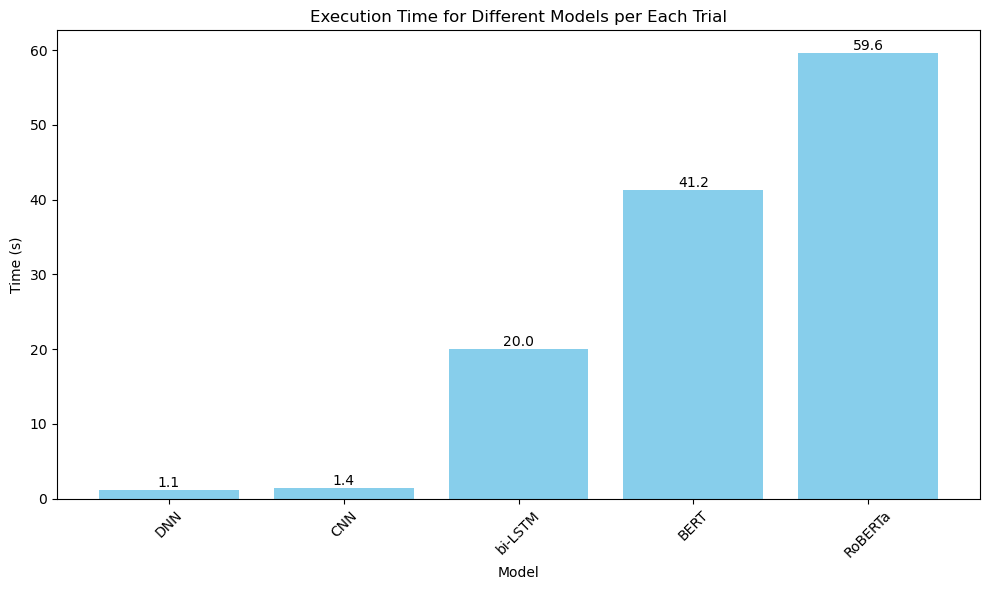

In [44]:
import matplotlib.pyplot as plt

time_DNN = 22.3 / 20
time_bi_LSTM = (39.9 + (6 * 60))/20
time_CNN = 28.3 / 20
time_BERT = (52.5 + (6 * 60))/10
time_RoBERTa = (56.5 + (9 * 60))/10
time_XMLRoBERTa = (54 + (24 * 60))/2

times = [time_DNN, time_bi_LSTM, time_CNN, time_BERT, time_RoBERTa]
names = ['DNN', 'bi-LSTM', 'CNN', 'BERT', 'RoBERTa']

sorted_data = sorted(zip(names, times), key=lambda x: x[1])
sorted_names, sorted_times = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_names, sorted_times, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Time (s)')
plt.title('Execution Time for Different Models per Each Trial')
plt.xticks(rotation=45)
plt.tight_layout()

# Add time values at the top of each bar
for bar, time in zip(bars, sorted_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{time:.1f}', ha='center', va='bottom')

plt.show()

In [51]:
best_model_DNN = dnn_tuner.get_best_models(num_models=1)[0]
best_model_DNN.fit(X_train_val, [y_train_val_valence, y_train_val_energy, y_train_val_danceability], epochs=20)

Epoch 1/20


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 12288, but received input with shape (32, 96)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32, 1), dtype=string)
  • training=True
  • mask=None

In [43]:
best_model_CNN = tuner_CNN.get_best_models(num_models=1)[0]
best_hyperparameters_CNN = tuner_CNN.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters_CNN.values)

{'embedding_output_dim': 96, 'filters': 96, 'kernel_size': 7, 'pool_size': 5, 'num_layers': 3, 'dense_units_1': 288, 'dropout_1': 0.0, 'optimizer': 'rmsprop', 'learning_rate': 0.001, 'dense_units_2': 224, 'dropout_2': 0.30000000000000004, 'dense_units_3': 32, 'dropout_3': 0.0}


In [60]:
import os
import json

def get_metric_value(metrics, key, default_value=None):
    """
    Helper function to safely extract metric value from the metrics dictionary.
    """
    if key in metrics:
        return metrics[key]['observations'][0]['value'][0]
    else:
        return default_value

def read_trial_metrics(trial_dir):
    trial_json = os.path.join(trial_dir, 'trial.json')
    with open(trial_json, 'r') as f:
        trial_data = json.load(f)

    metrics = trial_data['metrics']['metrics']

    val_danceability_acc = get_metric_value(metrics, 'val_danceability_output_accuracy')
    val_energy_acc = get_metric_value(metrics, 'val_energy_output_accuracy')
    val_valence_acc = get_metric_value(metrics, 'val_valence_output_accuracy')
    val_loss = get_metric_value(metrics, 'val_loss')

    danceability_acc = get_metric_value(metrics, 'danceability_output_accuracy')
    energy_acc = get_metric_value(metrics, 'energy_output_accuracy')
    valence_acc = get_metric_value(metrics, 'valence_output_accuracy')
    loss = get_metric_value(metrics, 'loss')

    return {
        'val_danceability_acc': val_danceability_acc,
        'val_energy_acc': val_energy_acc,
        'val_valence_acc': val_valence_acc,
        'val_loss': val_loss,
        'danceability_acc': danceability_acc,
        'energy_acc': energy_acc,
        'valence_acc': valence_acc,
        'loss': loss
    }

# Specify the parent directory containing the model folders
parent_dir = 'tuner_dir'

# Dictionary to store metrics for each model
all_model_metrics = {}

for model_dir in ['bi_lstm_mood_detection', 'cnn_mood_detection_600', 'dnn_mood_detection_600']:
    model_path = os.path.join(parent_dir, model_dir)

    # Dictionary to store metrics for all trials in this model
    model_metrics = {
        'val_danceability_acc': [],
        'val_energy_acc': [],
        'val_valence_acc': [],
        'val_loss': [],
        'danceability_acc': [],
        'energy_acc': [],
        'valence_acc': [],
        'loss': []
    }

    for trial_dir in os.listdir(model_path):
        if trial_dir.startswith('trial'):
            trial_path = os.path.join(model_path, trial_dir)
            metrics = read_trial_metrics(trial_path)
            # Append metrics to the respective lists in this model's dictionary
            model_metrics['val_danceability_acc'].append(metrics['val_danceability_acc'])
            model_metrics['val_energy_acc'].append(metrics['val_energy_acc'])
            model_metrics['val_valence_acc'].append(metrics['val_valence_acc'])
            model_metrics['val_loss'].append(metrics['val_loss'])
            model_metrics['danceability_acc'].append(metrics['danceability_acc'])
            model_metrics['energy_acc'].append(metrics['energy_acc'])
            model_metrics['valence_acc'].append(metrics['valence_acc'])
            model_metrics['loss'].append(metrics['loss'])
    
    valid_indices = [i for i, _ in enumerate(model_metrics['val_danceability_acc']) 
                     if None not in [model_metrics['val_danceability_acc'][i], 
                                     model_metrics['val_energy_acc'][i], 
                                     model_metrics['val_valence_acc'][i], 
                                     model_metrics['val_loss'][i], 
                                     model_metrics['danceability_acc'][i], 
                                     model_metrics['energy_acc'][i], 
                                     model_metrics['valence_acc'][i], 
                                     model_metrics['loss'][i]]]

    for key in model_metrics.keys():
        model_metrics[key] = [model_metrics[key][i] for i in valid_indices]
        
    # Store this model's metrics in the all_model_metrics dictionary
    all_model_metrics[model_dir] = model_metrics
    
for model, metrics in all_model_metrics.items():
    print(f"Metrics for model {model}:")
    for key, value in metrics.items():
        print(f"  {key}: {value}")
    print('-' * 40)

Metrics for model bi_lstm_mood_detection:
  val_danceability_acc: [0.4479166567325592, 0.40625, 0.3645833432674408, 0.4166666567325592, 0.4791666567325592, 0.2708333432674408, 0.5104166865348816, 0.4375, 0.3020833432674408, 0.4583333432674408]
  val_energy_acc: [0.2916666567325592, 0.34375, 0.3229166567325592, 0.3541666567325592, 0.40625, 0.2916666567325592, 0.3541666567325592, 0.46875, 0.2708333432674408, 0.3854166567325592]
  val_valence_acc: [0.5, 0.4791666567325592, 0.46875, 0.4375, 0.4270833432674408, 0.34375, 0.4583333432674408, 0.4479166567325592, 0.3645833432674408, 0.4479166567325592]
  val_loss: [3.2785587310791016, 3.1993112564086914, 3.294572591781616, 3.293623924255371, 3.1806838512420654, 3.290111541748047, 3.1452789306640625, 3.490560531616211, 3.2970426082611084, 3.189159393310547]
  danceability_acc: [0.5677083134651184, 0.4661458432674408, 0.2760416567325592, 0.3880208432674408, 0.5182291865348816, 0.3880208432674408, 0.4895833432674408, 0.5859375, 0.3515625, 0.473958

In [72]:
import matplotlib.pyplot as plt
val_list = ['val_danceability_acc', 'val_energy_acc', 'val_valence_acc']
acc_list = ['danceability_acc', 'energy_acc', 'valence_acc']

def var_sum(dict, selected_list):
    val_total = []
    for element in dict.values():
        val_acc_sum = []
        for i in range(len(element['val_danceability_acc'])):
            danceability = element['val_danceability_acc'][i]
            energy = element['val_energy_acc'][i]
            valence = element['val_valence_acc'][i]
            val_sum = ((danceability + energy + valence)/ 3) * 100
            val_acc_sum.append(val_sum)  
        val_total.append(val_acc_sum)

    return val_total
var_sum(all_model_metrics, val_list)

[[41.31944378217061,
  40.97222189108531,
  38.54166666666667,
  40.27777711550395,
  43.75,
  30.208333333333332,
  44.09722288449605,
  45.13888855775197,
  31.250000993410747,
  43.05555522441864],
 [40.27777810891469,
  48.95833333333333,
  30.902778108914692,
  35.76388955116272,
  37.15277711550395,
  44.09722189108531,
  45.13888855775197,
  34.375,
  34.02777711550395,
  33.33333333333333],
 [45.48611044883728,
  32.98611144224803,
  47.22222189108531,
  47.22222189108531,
  35.41666666666667,
  38.19444477558136,
  29.861110945542652,
  38.88888855775197]]

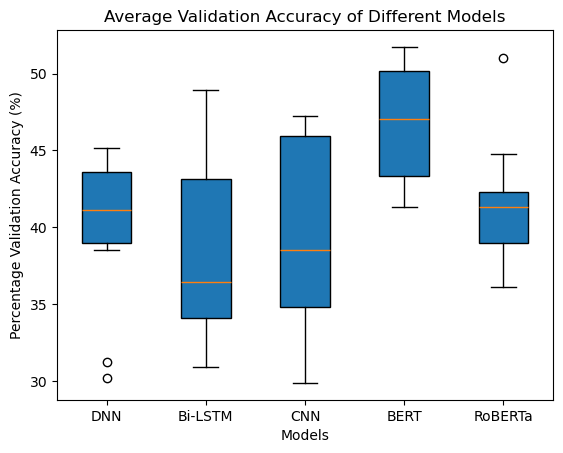

In [81]:
# Sample data (replace with your own lists)
dnn_val_accuracy, lstm_val_accuracy, cnn_val_accuracy = var_sum(all_model_metrics, val_list)
bert_tuned_val_accuracy = [41.32, 49.65, 42.36, 44.10, 50.69, 50.35, 46.53, 47.57, 51.74, 43.06]
roberta_tuned_val_accuracy = [36.11, 39.24, 37.15, 38.89, 42.01, 44.79, 51.04, 42.01, 40.62, 42.36]

# Create a figure and axis object
fig, ax = plt.subplots()

# Create the box plot
box_plot_accuracy = [dnn_val_accuracy, lstm_val_accuracy, cnn_val_accuracy, bert_tuned_val_accuracy, roberta_tuned_val_accuracy]
box = ax.boxplot(box_plot_accuracy, vert=True, patch_artist=True)

# Customize the appearance
ax.set_title('Average Validation Accuracy of Different Models')
ax.set_xlabel('Models')
ax.set_ylabel('Percentage Validation Accuracy (%)')

# Set the x-axis tick labels
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(['DNN', 'Bi-LSTM', 'CNN', 'BERT', 'RoBERTa'])

# Show the plot
plt.show()

In [78]:
roberta_list_acc = [
    "valence 37.76%, energy 44.53%, danceability 47.92%",
    "valence 38.28%, energy 40.62%, danceability 42.97%",
    "valence 36.46%, energy 44.27%, danceability 44.01%",
    "valence 36.72%, energy 40.62%, danceability 42.71%",
    "valence 58.85%, energy 64.06%, danceability 63.54%",
    "valence 50.26%, energy 51.56%, danceability 53.12%",
    "valence 86.46%, energy 86.72%, danceability 82.55%",
    "valence 44.79%, energy 47.66%, danceability 55.73%",
    "valence 36.98%, energy 44.53%, danceability 45.57%",
    "valence 76.56%, energy 65.89%, danceability 69.01%"
]

bert_list_acc = [
    "valence 46.88%, energy 46.09%, danceability 61.46%",
    "valence 77.60%, energy 73.96%, danceability 81.51%",
    "valence 45.57%, energy 52.08%, danceability 64.06%",
    "valence 60.68%, energy 52.60%, danceability 59.90%",
    "valence 69.01%, energy 72.92%, danceability 76.82%",
    "valence 83.07%, energy 85.42%, danceability 84.38%",
    "valence 69.53%, energy 60.94%, danceability 67.97%",
    "valence 77.60%, energy 66.15%, danceability 63.54%",
    "valence 64.32%, energy 73.18%, danceability 83.07%",
    "valence 40.62%, energy 45.31%, danceability 47.14%"
]

bert_numeric_acc = [
    [float(value.split('%')[0].split(' ')[-1]) for value in row.split(', ')]
    for row in bert_list_acc
]

roberta_numeric_acc = [
    [float(value.split('%')[0].split(' ')[-1]) for value in row.split(', ')]
    for row in roberta_list_acc
]

bert_valence_values = [val[0] for val in bert_numeric_acc]
bert_energy_values = [val[1] for val in bert_numeric_acc]
bert_danceability_values = [val[2] for val in bert_numeric_acc]

roberta_valence_values = [val[0] for val in roberta_numeric_acc]
roberta_energy_values = [val[1] for val in roberta_numeric_acc]
roberta_danceability_values = [val[2] for val in roberta_numeric_acc]

def sum_acc(a_list):
    bert_valence_values, bert_energy_values, bert_danceability_values = a_list
    average_values = []
    for i in range(len(bert_valence_values)):
        valence = bert_valence_values[i]
        energy = bert_energy_values[i]
        danceability = bert_danceability_values[i]
        average = round((valence + energy + danceability) / 3, 2)
        average_values.append(average)
    return average_values

bert_average_values = sum_acc([bert_valence_values, bert_energy_values, bert_danceability_values])
roberta_average_values = sum_acc([roberta_valence_values, roberta_energy_values, roberta_danceability_values])


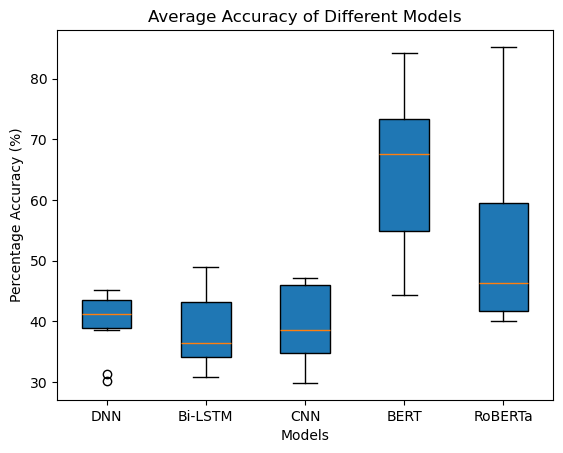

In [80]:
dnn_accuracy, lstm_accuracy, cnn_accuracy = var_sum(all_model_metrics, acc_list)
box_plot_train_accuracy = [dnn_accuracy, lstm_accuracy, cnn_accuracy, bert_average_values, roberta_average_values]

fig, ax = plt.subplots()
box = ax.boxplot(box_plot_train_accuracy, vert=True, patch_artist=True)

# Customize the appearance
ax.set_title('Average Accuracy of Different Models')
ax.set_xlabel('Models')
ax.set_ylabel('Percentage Accuracy (%)')

# Set the x-axis tick labels
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(['DNN', 'Bi-LSTM', 'CNN', 'BERT', 'RoBERTa'])

# Show the plot
plt.show()